<h1 style=font:garmond;font-size:50px;color:orange;text-align:left>Predict ML</h1>

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from main import Review, Timer#, Lottery

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Transformation</h2>

In [2]:
base_df = pd.read_csv('./Data/data.csv', names=['A', 'B', 'C', 'D', 'E', 'F'])
df = base_df.iloc[:-1]
# Using all but final row of dataframe for model, and final row as target for testing and model validation
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_dataframe = pd.DataFrame(data=transformed_dataset, index=df.index)

In [3]:
df.head()

,A,B,C,D,E,F
0,7,25,11,8,20,32
1,5,19,13,42,21,28
2,4,10,18,35,36,38
3,8,16,17,23,29,32
4,4,7,10,16,27,41


In [4]:
number_of_rows: int = df.values.shape[0]
number_of_features: int = df.values.shape[1]
window_size: int = 21

In [5]:
train = np.empty([number_of_rows-window_size, window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_size, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_size):
    train[i]=transformed_dataframe.iloc[i:i+window_size, 0: number_of_features]
    label[i]=transformed_dataframe.iloc[i+window_size: i+window_size+1, 0: number_of_features]

print(f'{train.shape=}\n{label.shape=}')

train.shape=(2058, 21, 6)
label.shape=(2058, 6)


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Training</h2>

In [6]:
LSTM_NODES: int = 240
DENSE_LAYERS: int = 6
DROPOUT_VARIANCE: float = 0.2

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=False)))
model.add(Dense(DENSE_LAYERS))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])    # NOQA

Metal device set to: Apple M1


2023-02-19 13:16:11.426459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 13:16:11.426585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
timer = Timer()
timer.start()

batch_size: int = 28
epochs: int = 3

history = model.fit(train, label, batch_size=batch_size, epochs=epochs)

timer.stop()

Epoch 1/3


2023-02-19 13:16:11.779108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-19 13:16:17.749863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:18.350077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:18.362919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:19.524329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:19.537045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:19.636579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

74/74 [==============================] - 19s 115ms/step - loss: 1.0128 - accuracy: 0.1725
Epoch 2/3
74/74 [==============================] - 7s 93ms/step - loss: 1.0065 - accuracy: 0.1749
Epoch 3/3
74/74 [==============================] - 7s 93ms/step - loss: 1.0023 - accuracy: 0.1740
Time taken: 32.73


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Prediction</h2>


In [9]:
timer.start()

to_predict = np.array(df)
scaled_to_predict = scaler.transform(to_predict)

scaled_prediction = model.predict(np.array([scaled_to_predict]))
np_prediction: List[int] = scaler.inverse_transform(scaled_prediction).astype(int)[0]

timer.stop()

print('\nPrediction: ', end='')
print(*np_prediction, sep=', ')

2023-02-19 13:16:46.396067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:46.563982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:16:46.574931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:17:04.207109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:17:04.221375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:17:21.086442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-19 13:17:21.098266: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 71s 71s/step
Time taken: 70.943

Prediction: 6, 12, 18, 23, 30, 36


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Result</h2>

In [10]:
prediction = list(np_prediction)
target = list(base_df.iloc[-1])
# Using all but final row of dataframe for model, and final row as target

# target: List[int] = Lottery(len(df)+2).collect(timer=True)
# Above using Lottery class to get draw result, however this is only to be used for functional methods once model is validated

quality = Review(prediction, target)
quality.show()

Prediction: 6, 12, 18, 23, 30, 36
Target: 5, 9, 14, 25, 30, 35


In [11]:
FILE_NAME: str = './Data/predictions.csv'
with open(FILE_NAME, 'a', encoding='UTF-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(np_prediction)

column_names: List[str] = ['A', 'B', 'C', 'D', 'E', 'F']
df2 = pd.read_csv('./Data/predictions.csv', names=column_names)

print(df2.iloc[-6:])

   A   B   C   D   E   F
0  6  13  18  24  31  36
1  6  12  18  24  29  37
2  6  12  18  24  30  36
3  1   3   9  24  36  41
4  7  12  17  23  28  35
5  6  12  18  23  30  36


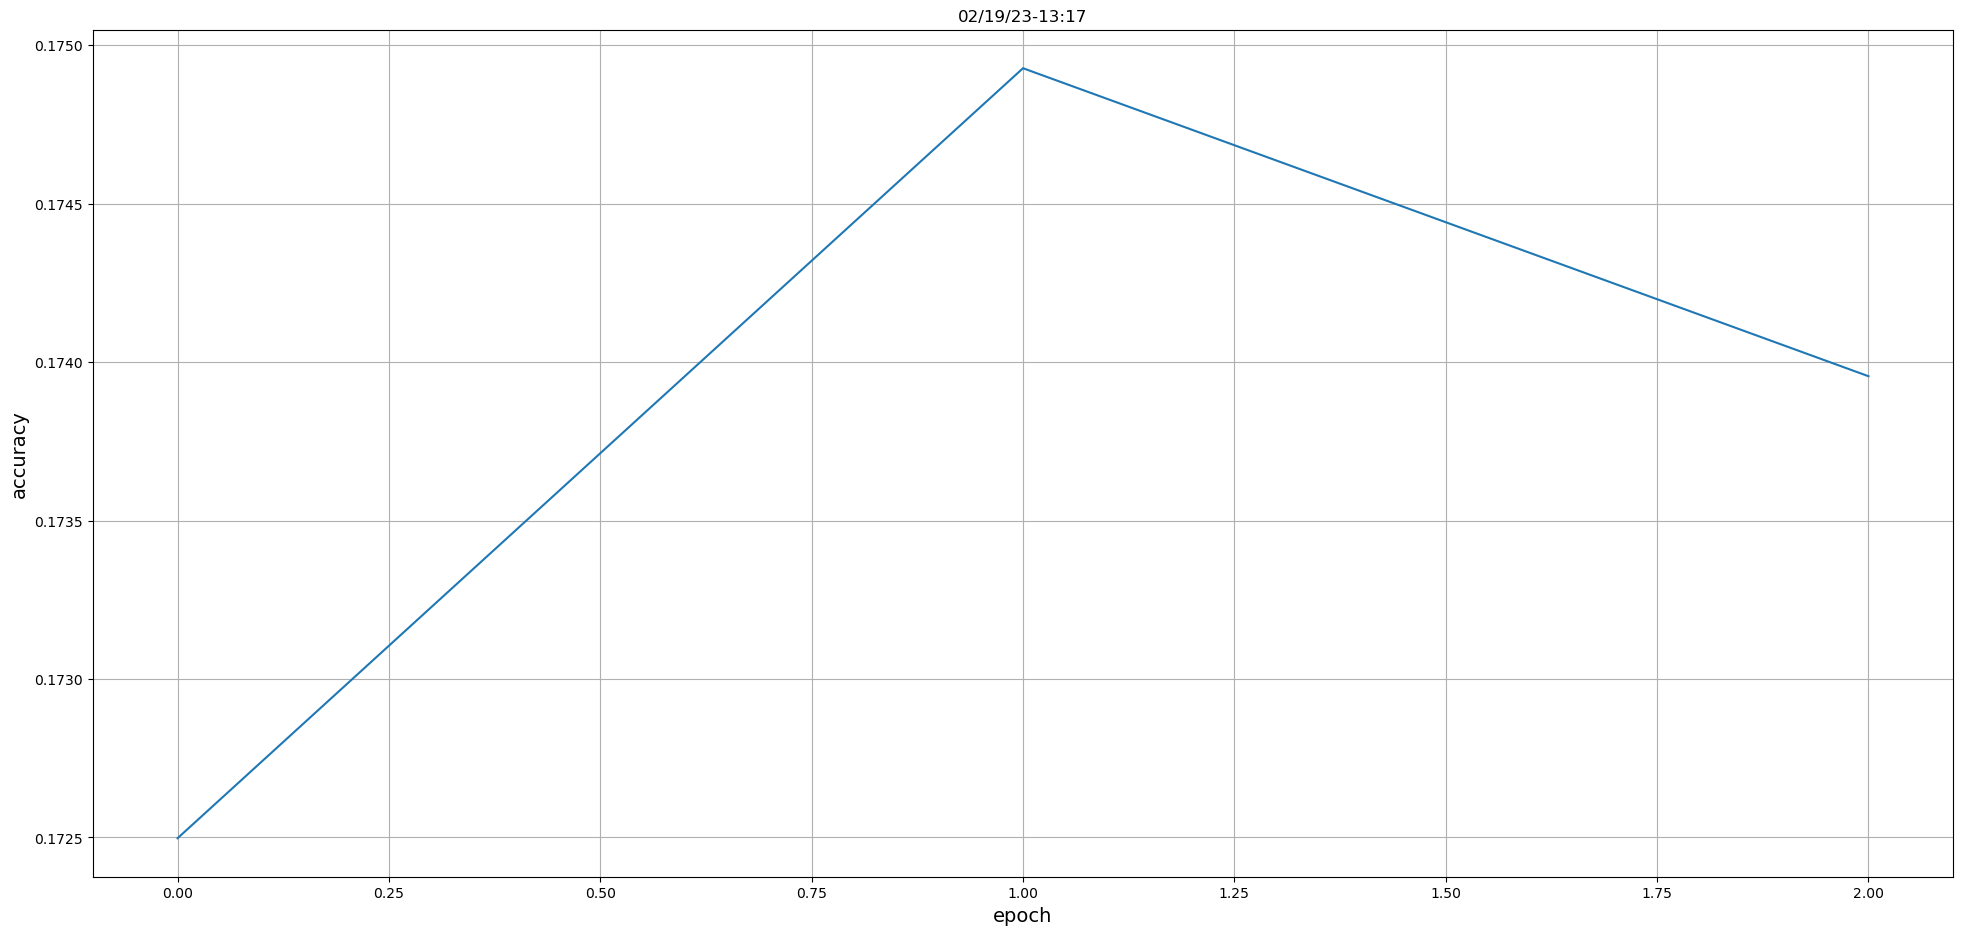

In [12]:
today: datetime = datetime.today()
now: datetime = datetime.now()

date_formatted: str = today.strftime('%m/%d/%y')
time_formatted: str = now.strftime('%H:%M')
title: str = f'{date_formatted}-{time_formatted}'

plt.figure(figsize=(24, 11))
plt.plot(history.history['accuracy'])
plt.title(title)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.grid()
plt.show()